# Basic CNN with Data Augmentation

In the previous section, we have created a simple CNN model and trained it with some 2000 images representing two sets of data. The model achieved a very good accuracy of the training set but the accuracy on the field data, i.e. data which is never seen in the training, is low (74%). This is a typical case of overfitting. One of the solutions to this problem is using more training data. Luckily Keras has an image generator for automatically generating images from the original data for training the neural network. We call this method "Data Augmentation".

The steps are more or less the same, with the exception of the data generation part.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import time

In [2]:
file_A = 'class_a.npy'
file_B = 'class_b.npy'
file_field = 'field.npy'

In [3]:
class_A = np.load(file_A)
class_B = np.load(file_B)
field = np.load(file_field)

In [4]:
print(class_A.shape)
print(class_B.shape)
print(field.shape)

(1000, 40, 60)
(1000, 40, 60)
(200, 40, 60)


In [5]:
print(np.max(class_A), np.min(class_A))

1.0 0.0


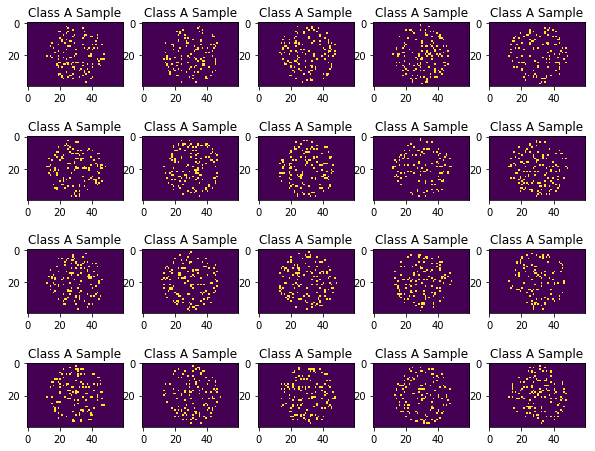

In [6]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title('Class A Sample')
    plt.imshow(class_A[i])

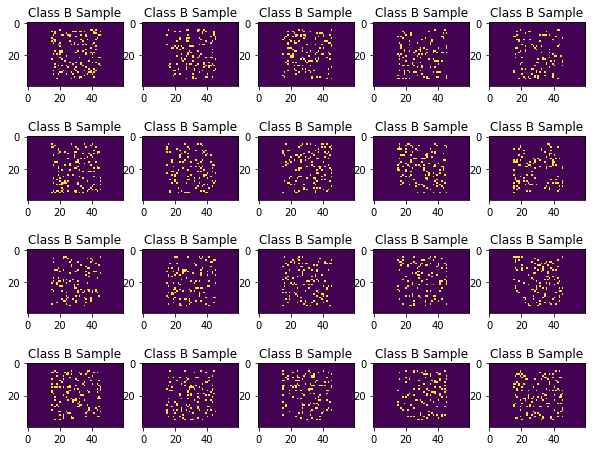

In [7]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title('Class B Sample')
    plt.imshow(class_B[i])

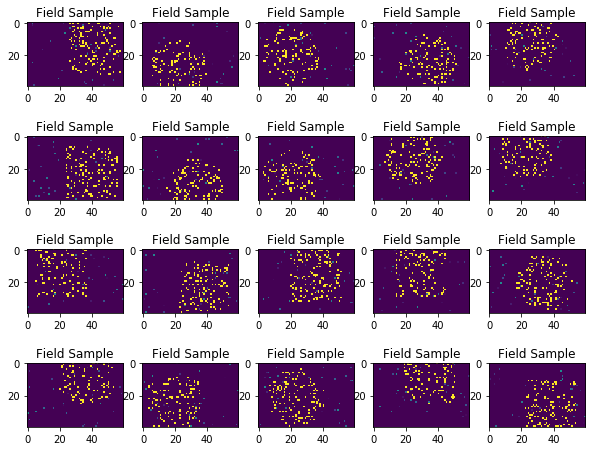

In [8]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title('Field Sample')
    plt.imshow(field[i])

Set some parameters

In [9]:
num, height, width = class_A.shape

In [10]:
train_img = np.concatenate((class_A, class_B), axis=0)
train_label = np.zeros(num*2)
train_label[num:] = 1

In [11]:
print(train_img.shape)

(2000, 40, 60)


In [12]:
print(train_label.shape)

(2000,)


In [13]:
# shuffle the image data and the respective labels randomly
np.random.seed(1234)

indices = np.random.permutation(train_img.shape[0])
train_img = train_img[indices]
train_label = train_label[indices]

[1. 0. 1. ... 1. 0. 0.]


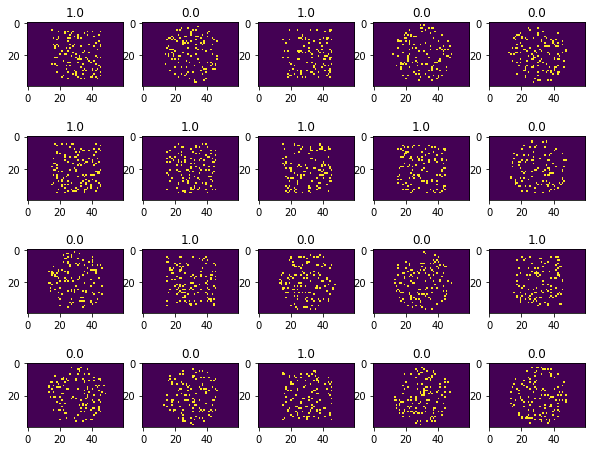

In [14]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(train_label[i])
    plt.imshow(train_img[i])
    
print(train_label)

In [15]:
train_img = np.expand_dims(train_img, axis = -1)

In [16]:
print(train_img.shape)

(2000, 40, 60, 1)


In [17]:
from keras.utils import np_utils
# perform one-hot encoding to the train labels
train_label = np_utils.to_categorical(train_label)

Using TensorFlow backend.


In [18]:
print(train_label)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [19]:
train_num = int(train_img.shape[0] * 0.8)

# split train and evaluation sets
x_Train = train_img[:train_num]
y_Train = train_label[:train_num]

x_Eval = train_img[train_num:]
y_Eval = train_label[train_num:]

In [20]:
print(x_Train.shape)
print(y_Train.shape)
print(x_Eval.shape)
print(y_Eval.shape)

(1600, 40, 60, 1)
(1600, 2)
(400, 40, 60, 1)
(400, 2)


In [21]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

In [22]:
NUM_CLASSES   = 2
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 400
WEIGHTS_FINAL = 'model_aug.h5'

In [23]:
# create helper function
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train], color="orange")
    plt.plot(train_history.history[validation], color="blue")
    plt.title('Train History')
    plt.xlabel('Epochs')
    plt.ylabel(train)
    plt.show()

In [24]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import optimizers
# create model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (height, width, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 58, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 13, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 11, 128)        73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 5, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 5, 128)         0         
__________

Instead of feeding the training set into the network for training directly, we use the ***ImageDataGenerator*** from Keras to generate augmented image data from the existing training set and test set. 

Note that in the field dataset, the dot patterns are shifted to the side of the image. Hence, we enter the *shear* and *shift_range* parameters into the ***ImageDataGenerator*** hopefully can generate some data with such characteristics.

In [25]:
train_datagen = ImageDataGenerator(#featurewise_center=True, 
                             rotation_range=90,
                             zoom_range=0.2,
                             shear_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

valid_datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)

In [26]:
batches = train_datagen.flow(x_Train, y_Train, batch_size=64)
x_batch, y_batch = next(batches)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


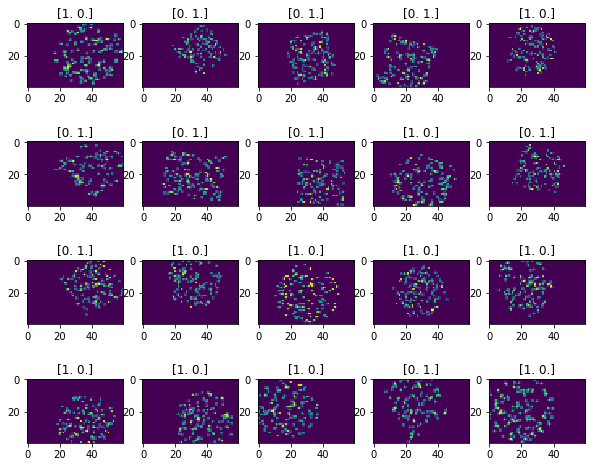

In [27]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(y_batch[i])
    plt.imshow(np.squeeze(x_batch[i], axis=2))
    plt.subplots_adjust(hspace=0.5)

We can see that some new image data has been generated with random rotation and translation based on the existing data. Let's feed the augmented data into training the original simple CNN.

In [28]:
start_time = time.time()
#train_history = model.fit(x_Train, y_Train, epochs=40, batch_size=128, validation_data=(x_Eval, y_Eval))

# since we are using ImageDataGenerator, we use fit_generator to feed the data into training.
train_history = model.fit_generator(train_datagen.flow(x_Train, y_Train, batch_size=BATCH_SIZE),
                                    #validation_data = (x_Eval, y_Eval),
                                    validation_data = valid_datagen.flow(x_Eval, y_Eval, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(x_Train) / BATCH_SIZE, epochs=NUM_EPOCHS)


end_time = time.time()

print("Training is complete. Total time taken in {:.2f}sec.".format((end_time - start_time)))

Epoch 1/400
50/50 [==============================] - 3s 53ms/step - loss: 0.6939 - acc: 0.4963 - val_loss: 0.6925 - val_acc: 0.5175
Epoch 2/400
50/50 [==============================] - 2s 49ms/step - loss: 0.6930 - acc: 0.5219 - val_loss: 0.6898 - val_acc: 0.5500
Epoch 3/400
50/50 [==============================] - 2s 49ms/step - loss: 0.6908 - acc: 0.5287 - val_loss: 0.6890 - val_acc: 0.5725
Epoch 4/400
50/50 [==============================] - 3s 51ms/step - loss: 0.6898 - acc: 0.5319 - val_loss: 0.6917 - val_acc: 0.5200
Epoch 5/400
50/50 [==============================] - 3s 50ms/step - loss: 0.6881 - acc: 0.5556 - val_loss: 0.6835 - val_acc: 0.5950
Epoch 6/400
50/50 [==============================] - 3s 51ms/step - loss: 0.6855 - acc: 0.5550 - val_loss: 0.6738 - val_acc: 0.6550
Epoch 7/400
50/50 [==============================] - 3s 51ms/step - loss: 0.6835 - acc: 0.5581 - val_loss: 0.6769 - val_acc: 0.5800
Epoch 8/400
50/50 [==============================] - 3s 51ms/step - loss: 0.

50/50 [==============================] - 2s 49ms/step - loss: 0.2442 - acc: 0.9062 - val_loss: 0.2178 - val_acc: 0.9225
Epoch 124/400
50/50 [==============================] - 3s 52ms/step - loss: 0.2620 - acc: 0.8988 - val_loss: 0.1628 - val_acc: 0.9500
Epoch 125/400
50/50 [==============================] - 3s 51ms/step - loss: 0.2259 - acc: 0.9150 - val_loss: 0.1960 - val_acc: 0.9300
Epoch 126/400
50/50 [==============================] - 3s 52ms/step - loss: 0.2410 - acc: 0.9106 - val_loss: 0.2025 - val_acc: 0.9275
Epoch 127/400
50/50 [==============================] - 3s 54ms/step - loss: 0.2571 - acc: 0.8950 - val_loss: 0.1728 - val_acc: 0.9425
Epoch 128/400
50/50 [==============================] - 3s 52ms/step - loss: 0.2254 - acc: 0.9025 - val_loss: 0.1862 - val_acc: 0.9300
Epoch 129/400
50/50 [==============================] - 3s 51ms/step - loss: 0.2456 - acc: 0.8988 - val_loss: 0.1672 - val_acc: 0.9325
Epoch 130/400
50/50 [==============================] - 3s 51ms/step - loss: 

50/50 [==============================] - 2s 49ms/step - loss: 0.1611 - acc: 0.9431 - val_loss: 0.1149 - val_acc: 0.9625
Epoch 246/400
50/50 [==============================] - 2s 50ms/step - loss: 0.1334 - acc: 0.9506 - val_loss: 0.0828 - val_acc: 0.9700
Epoch 247/400
50/50 [==============================] - 2s 50ms/step - loss: 0.1388 - acc: 0.9506 - val_loss: 0.0970 - val_acc: 0.9575
Epoch 248/400
50/50 [==============================] - 2s 49ms/step - loss: 0.1321 - acc: 0.9487 - val_loss: 0.1016 - val_acc: 0.9675
Epoch 249/400
50/50 [==============================] - 2s 49ms/step - loss: 0.1473 - acc: 0.9494 - val_loss: 0.0964 - val_acc: 0.9675
Epoch 250/400
50/50 [==============================] - 2s 49ms/step - loss: 0.1459 - acc: 0.9456 - val_loss: 0.1164 - val_acc: 0.9500
Epoch 251/400
50/50 [==============================] - 2s 49ms/step - loss: 0.1340 - acc: 0.9487 - val_loss: 0.1395 - val_acc: 0.9475
Epoch 252/400
50/50 [==============================] - 2s 49ms/step - loss: 

50/50 [==============================] - 3s 52ms/step - loss: 0.1164 - acc: 0.9562 - val_loss: 0.0785 - val_acc: 0.9675
Epoch 368/400
50/50 [==============================] - 3s 51ms/step - loss: 0.1040 - acc: 0.9663 - val_loss: 0.0830 - val_acc: 0.9775
Epoch 369/400
50/50 [==============================] - 3s 52ms/step - loss: 0.1224 - acc: 0.9569 - val_loss: 0.0934 - val_acc: 0.9625
Epoch 370/400
50/50 [==============================] - 3s 51ms/step - loss: 0.1149 - acc: 0.9562 - val_loss: 0.1008 - val_acc: 0.9700
Epoch 371/400
50/50 [==============================] - 3s 52ms/step - loss: 0.1033 - acc: 0.9631 - val_loss: 0.0559 - val_acc: 0.9900
Epoch 372/400
50/50 [==============================] - 3s 50ms/step - loss: 0.0957 - acc: 0.9631 - val_loss: 0.0784 - val_acc: 0.9700
Epoch 373/400
50/50 [==============================] - 3s 50ms/step - loss: 0.1103 - acc: 0.9625 - val_loss: 0.0765 - val_acc: 0.9675
Epoch 374/400
50/50 [==============================] - 3s 50ms/step - loss: 

!
Thu Oct 17 19:31:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.25       Driver Version: 415.25       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:01:00.0  On |                  N/A |
| 41%   40C    P8    27W / 280W |    531MiB / 24189MiB |     13%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      1213      G   /usr/lib/xorg/Xorg                           277MiB |
|    0      1365      G   /usr/bin/gnome-shell                         244MiB |
|    0      2772      G   /usr/lib/firefox/firefox                       3MiB |
|    0      2918      G   /usr/lib/firefox/firefox                       3MiB |
+-----------------------------------------------------------------------------+


In [29]:
score = model.evaluate(x_Eval, y_Eval, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.058030739570967854
Test accuracy: 0.98


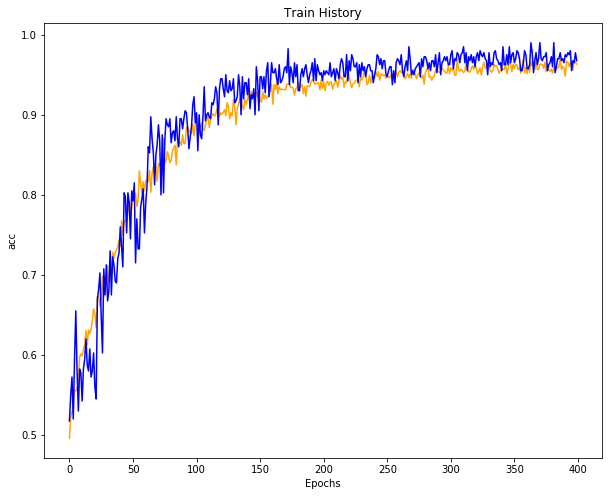

In [30]:
show_train_history(train_history, 'acc', 'val_acc')

Using **ImageDataGenerator**, the augmented images are generated endlessly and continuously flow into the model for training. The training time takes enormously longer (about 1000sec or 17min) using the same simple CNN. From the train history graph above, we can see that after 150 epoches, the performance of the model increases slowly, and becomes flat near 300th epochs.

Let's run the model with field data and compare the result with the previous one.

In [34]:
test_data = np.expand_dims(field, axis = -1)
print(test_data.shape)

(200, 40, 60, 1)


In [35]:
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)

In [36]:
print(predictions)

[1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1
 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0
 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0
 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1
 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0]


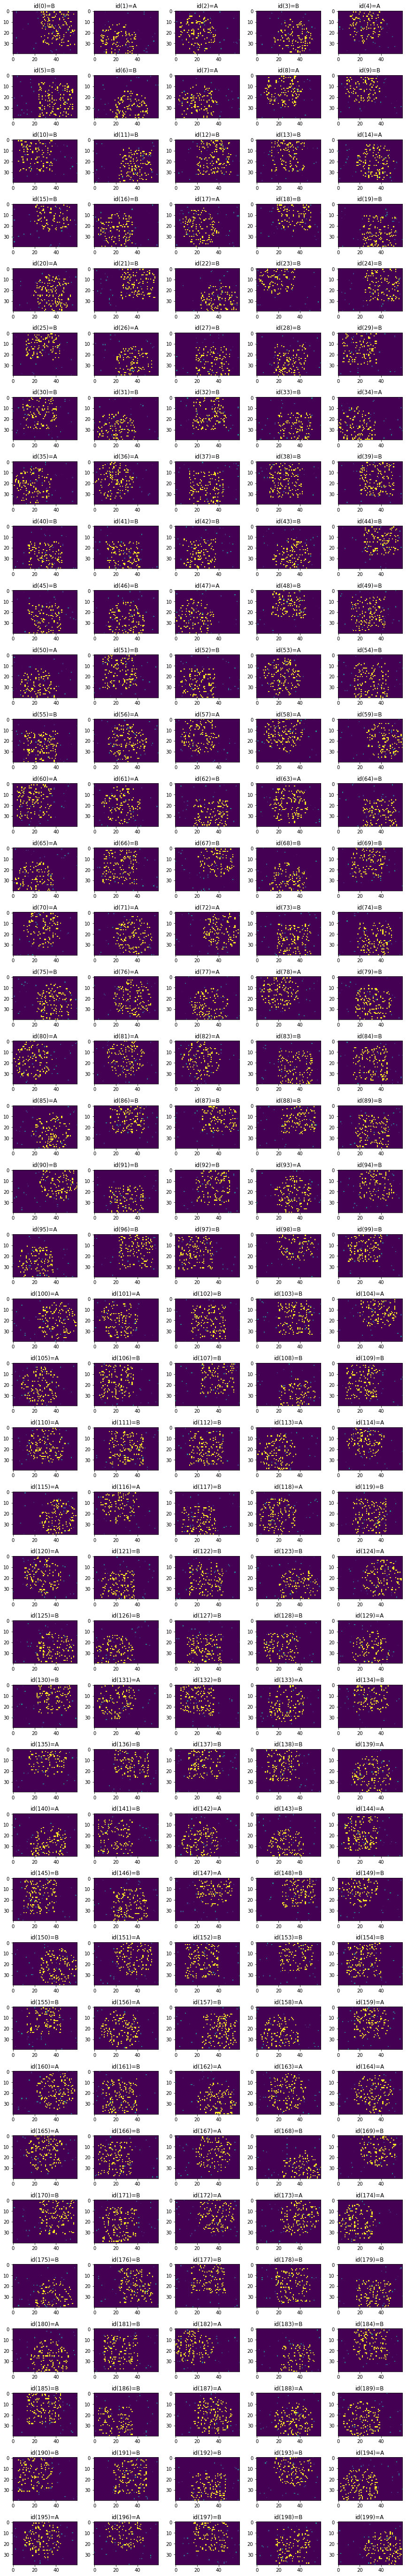

In [38]:
plt.rcParams['figure.figsize'] = (15.0,100.0)
for i in range(200):
    plt.subplot(40,5,i+1)
    if int(predictions[i]) == 1:
        ans = "B"
    else:
        ans = "A"
    plt.title("id("+str(i)+")="+ans)
    plt.imshow(field[i])
    plt.subplots_adjust(hspace=0.5)

+ id(3): B
+ id(6): B
+ id(9): B
+ id(15): B
+ id(23): B
+ id(31): B
+ id(43): B
+ id(46): B

Finally save the model weights into an external file.

In [39]:
model.save('model_data_gen.h5')